# Latent Dirichlet Allocation of Tweets

## 1. Introduction
In natural language processing, the Latent Dirichlet Allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.
We would like to determine the number of topics on tweets from Singapore collected in April 2021.

## 2. Exploratory data analysis

### 2.1 Load the data

In [1]:
import json

In [2]:
#import findspark
#findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, udf, lit

spark = SparkSession.builder.appName('read JSON files').getOrCreate()

In [4]:
# json_df=spark.read.option("inferSchema","true") \
#                 .option("header","true") \
#                 .option("sep",",") \
#                 .json("Mar*.json")

In [5]:
#json_df=spark.read.json("tweets.txt")

In [9]:
# sudo -u hdfs hdfs dfsadmin -safemode leave
# turn off safemode
# json_df=spark.read.json("hdfs://localhost:8020/user/cloudera/twitter_Extract")

In [8]:
json_df=spark.read.json("Apr_tweets*.json")

In [15]:
data_df=spark.read.json("data.json")

In [7]:
# number of files
json_df.count()

1

In [8]:
# show the schema
json_df.printSchema()

root
 |-- author_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- geo: struct (nullable = true)
 |    |-- place_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- public_metrics: struct (nullable = true)
 |    |-- like_count: long (nullable = true)
 |    |-- quote_count: long (nullable = true)
 |    |-- reply_count: long (nullable = true)
 |    |-- retweet_count: long (nullable = true)
 |-- text: string (nullable = true)



### 2.2 Select the json data

#### 2.2.1 Select tweet text json

In [11]:
# show the schema for tweets
json_df.select('data').printSchema()

root
 |-- data: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- author_id: string (nullable = true)
 |    |    |-- created_at: string (nullable = true)
 |    |    |-- geo: struct (nullable = true)
 |    |    |    |-- coordinates: struct (nullable = true)
 |    |    |    |    |-- coordinates: array (nullable = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |    |    |-- type: string (nullable = true)
 |    |    |    |-- place_id: string (nullable = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- public_metrics: struct (nullable = true)
 |    |    |    |-- like_count: long (nullable = true)
 |    |    |    |-- quote_count: long (nullable = true)
 |    |    |    |-- reply_count: long (nullable = true)
 |    |    |    |-- retweet_count: long (nullable = true)
 |    |    |-- text: string (nullable = true)



In [12]:
# convert array to dict
data_df=json_df.select('data').withColumn('data', explode('data').alias('data'))

In [10]:
# print the schema after conversion
data_df.printSchema()

root
 |-- author_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- geo: struct (nullable = true)
 |    |-- place_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- public_metrics: struct (nullable = true)
 |    |-- like_count: long (nullable = true)
 |    |-- quote_count: long (nullable = true)
 |    |-- reply_count: long (nullable = true)
 |    |-- retweet_count: long (nullable = true)
 |-- text: string (nullable = true)



In [16]:
# number of records
data_df.count()

1

In [ ]:
# select the attributes to flatten
data_df=data_df.select('data.author_id',
                       'data.created_at',
                       'data.geo.place_id',
                       'data.id',
                       'data.public_metrics',
                       'data.text')

In [17]:
# the schema after selection
data_df.printSchema()

root
 |-- author_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- geo: struct (nullable = true)
 |    |-- place_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- public_metrics: struct (nullable = true)
 |    |-- like_count: long (nullable = true)
 |    |-- quote_count: long (nullable = true)
 |    |-- reply_count: long (nullable = true)
 |    |-- retweet_count: long (nullable = true)
 |-- text: string (nullable = true)



#### 2.2.2 Select tweet place json

In [29]:
# select the place content
place_df=json_df.select('includes.places')

In [30]:
# show the schema fo place
place_df.printSchema()

root
 |-- places: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- country: string (nullable = true)
 |    |    |-- country_code: string (nullable = true)
 |    |    |-- full_name: string (nullable = true)
 |    |    |-- id: string (nullable = true)



#### 2.2.3 Select tweet user json

In [31]:
# select the user content
user_df=json_df.select('includes.users')

In [32]:
# show the schema fo user
user_df.printSchema()

root
 |-- users: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- location: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- username: string (nullable = true)



### 2.3 Unravel the nested json

In [18]:
import pyspark.sql.types as T
from pyspark.sql.functions import col

In [19]:
def read_nested_json(df):
    column_list = []

    for column_name in df.schema.names:
        print("Outside isinstance loop: " + column_name)
        # Checking column type is ArrayType
        if isinstance(df.schema[column_name].dataType, T.ArrayType):
            print("Inside isinstance loop of ArrayType: " + column_name)
            df = df.withColumn(column_name, explode(column_name).alias(column_name))
            column_list.append(column_name)

        elif isinstance(df.schema[column_name].dataType, T.StructType):
            print("Inside isinstance loop of StructType: " + column_name)
            for field in df.schema[column_name].dataType.fields:
                column_list.append(col(column_name + "." + field.name).alias(column_name + "_" + field.name))
        else:
            column_list.append(column_name)

    # Selecting columns using column_list from dataframe: df
    df = df.select(column_list)
    return df

In [20]:
def flatten_nested_json(df):
    read_nested_json_flag = True
    while read_nested_json_flag:
        print("Reading Nested JSON File ... ")
        df = read_nested_json(df)
        #df.show(100, False)
        read_nested_json_flag = False

        for column_name in df.schema.names:
            if isinstance(df.schema[column_name].dataType, T.ArrayType):
              read_nested_json_flag = True
            elif isinstance(df.schema[column_name].dataType, T.StructType):
              read_nested_json_flag = True
    return df

In [21]:
# flatten the tweet content
data_df=flatten_nested_json(data_df)

Reading Nested JSON File ... 
Outside isinstance loop: author_id
Outside isinstance loop: created_at
Outside isinstance loop: place_id
Outside isinstance loop: id
Outside isinstance loop: public_metrics
Inside isinstance loop of StructType: public_metrics
Outside isinstance loop: text


In [24]:
# show the first 10 records
data_df.show(10)

+-------------------+--------------------+----------------+-------------------+-------------------------+--------------------------+--------------------------+----------------------------+--------------------+
|          author_id|          created_at|        place_id|                 id|public_metrics_like_count|public_metrics_quote_count|public_metrics_reply_count|public_metrics_retweet_count|                text|
+-------------------+--------------------+----------------+-------------------+-------------------------+--------------------------+--------------------------+----------------------------+--------------------+
|1278250537972985856|2021-04-19T08:41:...|5f1f473ed6455f55|1384064534600507392|                        1|                         0|                         1|                           0|@hhjflrts im sorr...|
|           63608631|2021-04-19T08:41:...|58a4c3a0d54e1400|1384064515759693830|                        1|                         0|                         1| 

In [25]:
# check the number of record in data_df dataframe
data_df.createOrReplaceTempView("df_data")
spark.sql("SELECT count(*) FROM df_data").show()

+--------+
|count(1)|
+--------+
|   47978|
+--------+



In [26]:
# check that the id is the primary key
spark.sql("SELECT count(DISTINCT id) FROM df_data").show()

+------------------+
|count(DISTINCT id)|
+------------------+
|             47978|
+------------------+



In [33]:
# flatten the content for place
place_df=flatten_nested_json(place_df)

Reading Nested JSON File ... 
Outside isinstance loop: places
Inside isinstance loop of ArrayType: places
Reading Nested JSON File ... 
Outside isinstance loop: places
Inside isinstance loop of StructType: places


In [36]:
# check the number of unique place in place_df dataframe
place_df.createOrReplaceTempView("df_place")
spark.sql("SELECT count(*) FROM df_place").show()

+--------+
|count(1)|
+--------+
|    1502|
+--------+



In [39]:
# show the tweet location for first 100 records
place_df.show(100, False)

+--------------+-------------------+--------------------------------------------------+----------------+
|places_country|places_country_code|places_full_name                                  |places_id       |
+--------------+-------------------+--------------------------------------------------+----------------+
|Singapore     |SG                 |North-East Region, Singapore                      |5f1f473ed6455f55|
|Singapore     |SG                 |Central Region, Singapore                         |58a4c3a0d54e1400|
|Singapore     |SG                 |East Region, Singapore                            |6635b2fcebd13c64|
|Singapore     |SG                 |Singapore                                         |2509b9adc1fedfd2|
|Singapore     |SG                 |North Region, Singapore                           |14d9532bd696d8cb|
|Singapore     |SG                 |West Region, Singapore                            |0b37664066a8962a|
|Singapore     |SG                 |Lazarus Island     

In [40]:
# flatten the neseted json of user
user_df=flatten_nested_json(user_df)

Reading Nested JSON File ... 
Outside isinstance loop: users
Inside isinstance loop of ArrayType: users
Reading Nested JSON File ... 
Outside isinstance loop: users
Inside isinstance loop of StructType: users


In [44]:
# check the number of unique user in user_df dataframe
user_df.createOrReplaceTempView("df_user")
spark.sql("SELECT count(DISTINCT users_id) FROM df_user").show()

+------------------------+
|count(DISTINCT users_id)|
+------------------------+
|                    4374|
+------------------------+



In [45]:
# show the tweet user of first 100 records
user_df.show(100, False)

+-------------------+------------------------------+--------------------------------+---------------+
|users_id           |users_location                |users_name                      |users_username |
+-------------------+------------------------------+--------------------------------+---------------+
|1278250537972985856|stayville / chan's room       |skztrees                        |skztrees       |
|63608631           |A Galaxy Far Far Away...      |Я.                              |raguugar       |
|125625919          |Singapore                     |Lexelle de Charmaine            |lexelledextjluv|
|1357206521407434752|Myanmar                       |HninOo05                        |HninOoWai05    |
|24787145           |Singapore                     |SGFirstAid                      |sfatc          |
|74392791           |Central Region, Singapore     |Abu Zimal                       |chat2deen      |
|6988732            |Singapore                     |Daphne Maia                   

In [47]:
# show the user with user location not null
spark.sql("SELECT DISTINCT (users_name,users_location) FROM df_data where users_location is not null").count()

3446

## 3. Modelling

In [50]:
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from gensim.models import LsiModel

/home/cloudera/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [51]:
# get the tweet text 
raw_tweets = data_df.select('id','created_at','text')

In [52]:
# show the first 10 records
raw_tweets.show(10)

+-------------------+--------------------+--------------------+
|                 id|          created_at|                text|
+-------------------+--------------------+--------------------+
|1384064534600507392|2021-04-19T08:41:...|@hhjflrts im sorr...|
|1384064515759693830|2021-04-19T08:41:...|@yogezlor By now ...|
|1384064394011709446|2021-04-19T08:40:...|Forgot about the ...|
|1384064393017626635|2021-04-19T08:40:...|Massive protester...|
|1384063860852678657|2021-04-19T08:38:...|Just posted a pho...|
|1384063582938140673|2021-04-19T08:37:...|@Ibraheema_Ykb Ok...|
|1384063508652851200|2021-04-19T08:37:...|@mintea AND KIDS....|
|1384063029076127747|2021-04-19T08:35:...|Just posted a pho...|
|1384062369492389892|2021-04-19T08:32:...|@SheaSonia I am s...|
|1384062319781502977|2021-04-19T08:32:...|In MyinGyan, terr...|
+-------------------+--------------------+--------------------+
only showing top 10 rows



In [53]:
# the schema for raw tweets
raw_tweets.printSchema()

root
 |-- id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- text: string (nullable = true)



### 3.1 Prepocess

#### 3.1.1 Remove non-text component

In [54]:
# Preprocess steps
import re
from pyspark.sql.functions import udf
from pyspark.sql.functions import to_timestamp
import pyspark.sql.types as T

In [55]:
# convert create_at column to date
raw_tweets=raw_tweets.withColumn("created_date", raw_tweets['created_at'].cast(T.DateType()))

In [58]:
# define process function
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@â'
def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet) 
    tweet = re.sub(r'bit.ly/\S+', '', tweet) 
    tweet = tweet.strip('[link]') 
    return tweet
def remove_users(tweet):
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    return tweet
def remove_punctuation(tweet):
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) 
    return tweet
def remove_number(tweet):
    tweet = re.sub('([0-9]+)', '', tweet) 
    return tweet
def remove_hashtag(tweet):
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    return tweet

In [59]:
# register user defined function
remove_links=udf(remove_links)
remove_users=udf(remove_users)
remove_punctuation=udf(remove_punctuation)
remove_number=udf(remove_number)
remove_hashtag=udf(remove_hashtag)

In [60]:
raw_tweets=raw_tweets.withColumn('processed_text', remove_links(raw_tweets['text']))

In [61]:
raw_tweets=raw_tweets.withColumn('processed_text', remove_users(raw_tweets['processed_text']))

In [62]:
raw_tweets=raw_tweets.withColumn('processed_text', remove_punctuation(raw_tweets['processed_text']))

In [63]:
raw_tweets=raw_tweets.withColumn('processed_text', remove_number(raw_tweets['processed_text']))

In [64]:
#raw_tweets=raw_tweets.withColumn('processed_text', remove_hashtag(raw_tweets['processed_text']))

In [67]:
# show the data before and after pocessed
raw_tweets.select('text','processed_text').show(10, False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                          |processed_text                                                                                                                                        

#### 3.1.2 Tokenization

In [68]:
# Create a tokenizer that Filter away tokens with length < 3, and get rid of symbols like $,#,...
tokenizer = RegexTokenizer().setPattern("[\\W_]+").setMinTokenLength(3).setInputCol("processed_text").setOutputCol("tokens")

In [69]:
#tokenizer = RegexTokenizer().setPattern("^[a-zA-Z]+\\b").setMinTokenLength(3).setInputCol("text").setOutputCol("tokens")

In [70]:
# Tokenize tweets
tokenized_tweets = tokenizer.transform(raw_tweets)

In [71]:
# display the original text, processed text and tokenized text
tokenized_tweets.select('text','processed_text','tokens').show(50)

+--------------------+--------------------+--------------------+
|                text|      processed_text|              tokens|
+--------------------+--------------------+--------------------+
|@hhjflrts im sorr...| im sorry if i co...|[sorry, come, out...|
|@yogezlor By now ...| By now you shoul...|[now, you, should...|
|Forgot about the ...|Forgot about the ...|[forgot, about, t...|
|Massive protester...|Massive protester...|[massive, protest...|
|Just posted a pho...|Just posted a pho...|[just, posted, ph...|
|@Ibraheema_Ykb Ok...| Ok  Times have g...|[times, have, gon...|
|@mintea AND KIDS....| AND KIDS  Who do...|[and, kids, who, ...|
|Just posted a pho...|Just posted a pho...|[just, posted, ph...|
|@SheaSonia I am s...| I am so heartbro...|[heartbroken, hea...|
|In MyinGyan, terr...|In MyinGyan  terr...|[myingyan, terror...|
|In Myingyan, Mand...|In Myingyan  Mand...|[myingyan, mandal...|
|        Exhausted 😣|        Exhausted 😣|         [exhausted]|
|@HaroldYeddo Love...| Love

#### 3.1.3 Lemmatize

In [84]:
# perform lemmatization using wordNetLemmatizer
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
#from nltk.stem.lancaster import LancasterStemmer
#from nltk import SnowballStemmer
#from nltk.stem import PorterStemmer

lemmatizer = WordNetLemmatizer()
#st = LancasterStemmer()
#stemmer = SnowballStemmer("english")
#stemmer=PorterStemmer()

def lemmatization(row):
    #row = [stemmer.stem(lemmatizer.lemmatize(word)) for word in row]
    row = [lemmatizer.lemmatize(word,'v') for word in row]
    return row

lemmatization = udf(lemmatization)
tokenized_tweets=tokenized_tweets.withColumn('tokens_lemma', lemmatization(tokenized_tweets['tokens']))

[nltk_data] Downloading package wordnet to /home/cloudera/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [85]:
tokenized_tweets.select('processed_text','tokens','tokens_lemma').show(50)

+--------------------+--------------------+--------------------+
|      processed_text|              tokens|        tokens_lemma|
+--------------------+--------------------+--------------------+
| im sorry if i co...|[sorry, come, out...|[sorry, come, out...|
| By now you shoul...|[now, you, should...|[now, you, should...|
|Forgot about the ...|[forgot, about, t...|[forget, about, t...|
|Massive protester...|[massive, protest...|[massive, protest...|
|Just posted a pho...|[just, posted, ph...|[just, post, phot...|
| Ok  Times have g...|[times, have, gon...|[time, have, go, ...|
| AND KIDS  Who do...|[and, kids, who, ...|[and, kid, who, d...|
|Just posted a pho...|[just, posted, ph...|[just, post, phot...|
| I am so heartbro...|[heartbroken, hea...|[heartbroken, hea...|
|In MyinGyan  terr...|[myingyan, terror...|[myingyan, terror...|
|In Myingyan  Mand...|[myingyan, mandal...|[myingyan, mandal...|
|        Exhausted 😣|         [exhausted]|           [exhaust]|
| Love it anak 🙏🏻♥️|      

#### 3.1.4 Remove stop word

In [88]:
# create cutomized extended stop word list
stopwordList = ["singapore","Singapore"]
StopWordsRemover().getStopWords()
stopwordList.extend(StopWordsRemover().getStopWords())
stopwordList = list(set(stopwordList))

In [89]:
# reference: https://sites.google.com/site/iamgongwei/home/sw
# this is a twitter specific stop word summarized by SMU researcher
# to add more common stopwords,especially in twitter context
f_twitter_stop_words = open('twitter-stopwords - TA - Less.txt','r')
f_twitter_stop_words_content = f_twitter_stop_words.read()
#print(content)
twitter_stopwords = f_twitter_stop_words_content.split(",")
twitter_stopwords

['.com',
 '.ly',
 '.net',
 '.org',
 'aahh',
 'aarrgghh',
 'abt',
 'ftl',
 'ftw',
 'fu',
 'fuck',
 'fucks',
 'gtfo',
 'gtg',
 'haa',
 'hah',
 'hahah',
 'haha',
 'hahaha',
 'hahahaha',
 'hehe',
 'heh',
 'hehehe',
 'hi',
 'hihi',
 'hihihi',
 'http',
 'https',
 'huge',
 'huh',
 'huhu',
 'huhuhu',
 'idk',
 'iirc',
 'im',
 'imho',
 'imo',
 'ini',
 'irl',
 'ish',
 'isn',
 'isnt',
 'j/k',
 'jk',
 'jus',
 'just',
 'justwit',
 'juz',
 'kinda',
 'kthx',
 'kthxbai',
 'kyou',
 'laa',
 'laaa',
 'lah',
 'lanuch',
 'leavg',
 'leh',
 'lol',
 'lols',
 'ltd',
 'mph',
 'mrt',
 'msg',
 'msgs',
 'muahahahahaha',
 'nb',
 'neways',
 'ni',
 'nice',
 'pls',
 'plz',
 'plzz',
 'psd',
 'pte',
 'pwm',
 'pwned',
 'qfmft',
 'qft',
 'tis',
 'tm',
 'tmr',
 'tyty',
 'tyvm',
 'um',
 'umm',
 'viv',
 'vn',
 'vote',
 'voted',
 'w00t',
 'wa',
 'wadever',
 'wah',
 'wasn',
 'wasnt',
 'wassup',
 'wat',
 'watcha',
 'wateva',
 'watever',
 'watnot',
 'wats',
 'wayy',
 'wb',
 'weren',
 'werent',
 'whaha',
 'wham',
 'whammy',
 'whao

In [90]:
# adding to the list of stop word
stopwordList.extend(twitter_stopwords)
stopwordList = list(set(stopwordList))

In [91]:
# Create a remover that Filter away stop word
remover = StopWordsRemover(stopWords=stopwordList).setInputCol("tokens").setOutputCol("cleaned")

In [92]:
# remove stopwords
cleaned_tweets = remover.transform(tokenized_tweets)

In [93]:
# show the result after preprocessed
cleaned_tweets.show()

+-------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+
|                 id|          created_at|                text|created_date|      processed_text|              tokens|        tokens_lemma|             cleaned|
+-------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+
|1384064534600507392|2021-04-19T08:41:...|@hhjflrts im sorr...|  2021-04-19| im sorry if i co...|[sorry, come, out...|[sorry, come, out...|[sorry, come, ign...|
|1384064515759693830|2021-04-19T08:41:...|@yogezlor By now ...|  2021-04-19| By now you shoul...|[now, you, should...|[now, you, should...|[know, fan, base,...|
|1384064394011709446|2021-04-19T08:40:...|Forgot about the ...|  2021-04-19|Forgot about the ...|[forgot, about, t...|[forget, about, t...|[forgot, wire, ta...|
|1384064393017626635|2021-04-19T08

### 3.2 Vectorize the clean tokens

In [94]:
# create a vector of words that at least appeared in two different tweets, and set maximum vocab size to 20000.
vectorizer = CountVectorizer().setInputCol("cleaned").setOutputCol("features").setVocabSize(20000).setMinDF(2).fit(cleaned_tweets)
wordVectors = vectorizer.transform(cleaned_tweets)

In [95]:
wordVectors.show()

+-------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 id|          created_at|                text|created_date|      processed_text|              tokens|        tokens_lemma|             cleaned|            features|
+-------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|1384064534600507392|2021-04-19T08:41:...|@hhjflrts im sorr...|  2021-04-19| im sorry if i co...|[sorry, come, out...|[sorry, come, out...|[sorry, come, ign...|(18035,[79,296,29...|
|1384064515759693830|2021-04-19T08:41:...|@yogezlor By now ...|  2021-04-19| By now you shoul...|[now, you, should...|[now, you, should...|[know, fan, base,...|(18035,[25,219,80...|
|1384064394011709446|2021-04-19T08:40:...|Forgot about the ...|  2021-04-19|Forgot about t

### 3.3 Grid search the optimal number of topics

In [75]:
# set number of topic 
# set the mertic to evaluate model performance
num_topics=range(2,11)
models=[]
log_likeli=[]
log_perp=[]
for num in num_topics:
    # LDA
    # create Latent Dirichlet Allocation model and run it on our data with 50 iteration and selected topics number
    lda = LDA(k=num, maxIter=50)
    # fit the model on data
    ldaModel = lda.fit(wordVectors)
    models.append(ldaModel)
    ll = ldaModel.logLikelihood(wordVectors)
    lp = ldaModel.logPerplexity(wordVectors)
    log_likeli.append(ll)
    log_perp.append(lp)

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
plot_data=pd.DataFrame(list(zip(num_topics,log_likeli,log_perp)),
            columns=['topics_num','logLikelihood','logPerplexity'])

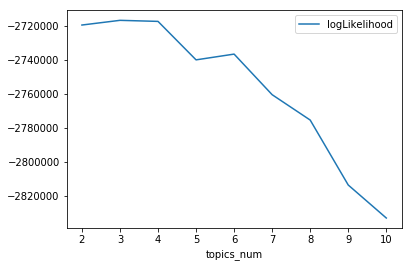

In [78]:
# use the elbow method to determine the optimal k
plot_data.plot(x='topics_num',y='logLikelihood',kind = 'line')
plt.show()

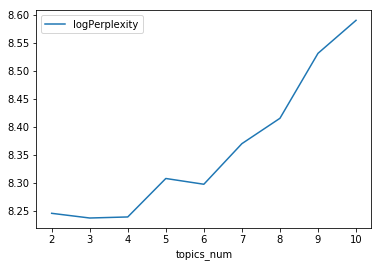

In [79]:
# use the elbow method to determine the optimal k
plot_data.plot(x='topics_num',y='logPerplexity',kind = 'line')
plt.show()

In [ ]:
model=models[2]

#### 3.3.1 use the optimal k to build model

In [96]:
# LDA
# create Latent Dirichlet Allocation model and run it on our data with 50 iteration and selected topics number
lda = LDA(k=6, maxIter=100)
# fit the model on data
model = lda.fit(wordVectors)

In [98]:
ll = model.logLikelihood(wordVectors)
lp = model.logPerplexity(wordVectors)

In [99]:
print("The lower bound on the log likelihood of the entire corpus: ",ll)
print("The upper bound on perplexity: ",lp)

The lower bound on the log likelihood of the entire corpus:  -2799276.690199641
The upper bound on perplexity:  8.182052969682458


## 4. Result 

In [100]:
# extract vocabulary from CountVectorizer
vocab = vectorizer.vocabulary

In [101]:
# create topics based on LDA
lda_topics = model.describeTopics()
lda_topics.show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[0, 1, 2, 3, 4, 8...|[0.04057948285869...|
|    1|[592, 493, 625, 8...|[0.00515984500434...|
|    2|[14, 6, 13, 17, 1...|[0.01018599466956...|
|    3|[6, 7, 5, 29, 20,...|[0.00644654426816...|
|    4|[266, 220, 336, 4...|[0.01292840517514...|
|    5|[18, 45, 43, 84, ...|[0.03786730164264...|
+-----+--------------------+--------------------+



In [102]:
lda_topics.select('termWeights').show(10,False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|termWeights                                                                                                                                                                                                                    |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.04057948285869612, 0.03580110191581833, 0.028785263446177666, 0.02806167509572159, 0.01659809681602015, 0.013287493213238574, 0.012123839165950908, 0.009582735702510219, 0.008965910615352986, 0.006967276682229401]       |
|[0.005159845004340383, 0.005124988843231104, 0.004968759578156371, 0.0048600968093015645, 0.004

In [103]:
lda_topics.select('termIndices').show(10,False)

+--------------------------------------------------+
|termIndices                                       |
+--------------------------------------------------+
|[0, 1, 2, 3, 4, 8, 10, 16, 15, 5]                 |
|[592, 493, 625, 88, 830, 366, 221, 793, 509, 1133]|
|[14, 6, 13, 17, 19, 9, 11, 12, 28, 31]            |
|[6, 7, 5, 29, 20, 33, 12, 25, 82, 35]             |
|[266, 220, 336, 426, 200, 532, 68, 484, 479, 11]  |
|[18, 45, 43, 84, 116, 93, 121, 117, 57, 110]      |
+--------------------------------------------------+



In [104]:
topics_rdd = lda_topics.rdd
topics_words = topics_rdd\
       .map(lambda row: row['termIndices'])\
       .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
       .collect()

for idx, topic in enumerate(topics_words):
    print("topic: {}".format(idx))
    print("*"*25)
    for word in topic:
       print(word)
    print("*"*25)

topic: 0
*************************
whatshappeninginmyanmar
aprcoup
posted
photo
military
terrorists
junta
abducted
myanmar
amp
*************************
topic: 1
*************************
sun
view
collection
food
sat
women
full
field
available
interpol
*************************
topic: 2
*************************
edwardbarber
like
love
edward
barber
day
good
get
happy
life
*************************
topic: 3
*************************
like
people
amp
see
need
please
get
know
help
really
*************************
topic: 4
*************************
btc
cute
chef
crypto
pretty
greed
april
silver
bistro
good
*************************
topic: 5
*************************
free
zerowaste
part
different
cool
future
nftcollectors
nftcommunity
city
miss
*************************


In [117]:
transformed = model.transform(wordVectors)
transformed.show(10)

+-------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 id|          created_at|                text|created_date|      processed_text|              tokens|        tokens_lemma|             cleaned|            features|   topicDistribution|
+-------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|1384064534600507392|2021-04-19T08:41:...|@hhjflrts im sorr...|  2021-04-19| im sorry if i co...|[sorry, come, out...|[sorry, come, out...|[sorry, come, ign...|(18035,[79,296,29...|[0.02361362781276...|
|1384064515759693830|2021-04-19T08:41:...|@yogezlor By now ...|  2021-04-19| By now you shoul...|[now, you, should...|[now, you, should...|[know, fan, base,...|(18035,[25,219,80...|[0.0234

In [118]:
transformed.printSchema()

root
 |-- id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- text: string (nullable = true)
 |-- created_date: date (nullable = true)
 |-- processed_text: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_lemma: string (nullable = true)
 |-- cleaned: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- topicDistribution: vector (nullable = true)



In [128]:
to_array = udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))

In [129]:
max_index = udf(lambda x: x.index(__builtin__.max(x)) if x is not None else None, T.IntegerType())

In [130]:
topic_index = udf(lambda x: 'topic'+str(x), T.StringType())

In [131]:
key_word = udf(lambda x: ', '.join(topics_words[x]), T.StringType())

In [132]:
transformed=transformed.withColumn('topicDistribution_array', to_array(transformed['topicDistribution']))
transformed=transformed.withColumn('dominant_topic_index', max_index(transformed['topicDistribution_array']))

In [133]:
transformed=transformed.withColumn('dominant_topic', topic_index(transformed['dominant_topic_index']))

In [134]:
transformed=transformed.withColumn('dominant_topic_keywords', key_word(transformed['dominant_topic_index']))

In [135]:
transformed.schema

StructType(List(StructField(id,StringType,true),StructField(created_at,StringType,true),StructField(text,StringType,true),StructField(created_date,DateType,true),StructField(processed_text,StringType,true),StructField(tokens,ArrayType(StringType,true),true),StructField(tokens_lemma,StringType,true),StructField(cleaned,ArrayType(StringType,true),true),StructField(features,VectorUDT,true),StructField(topicDistribution,VectorUDT,true),StructField(topicDistribution_array,ArrayType(FloatType,true),true),StructField(dominant_topic_index,IntegerType,true),StructField(dominant_topic,StringType,true),StructField(dominant_topic_keywords,StringType,true)))

In [137]:
transformed.select('topicDistribution_array','dominant_topic','dominant_topic_keywords').show(20, False)

+-------------------------------------------------------------------------------+--------------+----------------------------------------------------------------------------------------------------+
|topicDistribution_array                                                        |dominant_topic|dominant_topic_keywords                                                                             |
+-------------------------------------------------------------------------------+--------------+----------------------------------------------------------------------------------------------------+
|[0.023613628, 0.012934124, 0.38034496, 0.5562978, 0.013239422, 0.013570069]    |topic3        |like, people, amp, see, need, please, get, know, help, really                                       |
|[0.023478504, 0.439182, 0.48582342, 0.024705682, 0.013239427, 0.013570952]     |topic2        |edwardbarber, like, love, edward, barber, day, good, get, happy, life                               |
|[0.023687

In [141]:
transformed.groupBy("created_date","dominant_topic","dominant_topic_keywords").count().orderBy("created_date","dominant_topic").show()

+------------+--------------+-----------------------+-----+
|created_date|dominant_topic|dominant_topic_keywords|count|
+------------+--------------+-----------------------+-----+
|  2021-04-01|        topic0|   whatshappeninginm...|  367|
|  2021-04-01|        topic1|   sun, view, collec...|   59|
|  2021-04-01|        topic2|   edwardbarber, lik...|  568|
|  2021-04-01|        topic3|   like, people, amp...|  399|
|  2021-04-01|        topic4|   btc, cute, chef, ...|   80|
|  2021-04-01|        topic5|   free, zerowaste, ...|   89|
|  2021-04-02|        topic0|   whatshappeninginm...|  401|
|  2021-04-02|        topic1|   sun, view, collec...|   63|
|  2021-04-02|        topic2|   edwardbarber, lik...|  649|
|  2021-04-02|        topic3|   like, people, amp...|  327|
|  2021-04-02|        topic4|   btc, cute, chef, ...|   83|
|  2021-04-02|        topic5|   free, zerowaste, ...|  123|
|  2021-04-03|        topic0|   whatshappeninginm...|  426|
|  2021-04-03|        topic1|   sun, vie

In [113]:
# save the result
# transformed.groupBy("created_date","dominant_topic").count().toPandas().to_csv('AprTopics.csv')

In [143]:
transformed.groupBy("created_date","dominant_topic","dominant_topic_keywords").count().repartition(1).write.csv('AprTopics.csv', header='true')